# Fine Tuning

## Installing Requirements and Mounting Drive

In [ ]:
! pip install transformers datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Make Primary Dataset

In [ ]:
import os
import json
import pandas as pd

### Read Data Files and Create DataFrame

We use `gossipcop` for fine-tuning.

In [ ]:
gossipcop_path = 'drive/MyDrive/LLM/FinalProject/gossipcop'

labels = ['fake', 'real']
json_file_name = "news content.json"

As there are $2988$ samples labled 'fake' in `gossipcop`, we shoose $3000$ samples labled 'real' to have a balanced dataset.

In [ ]:
def read_news_files(base_path, dataset_name, title_col, content_col, *cols):
    data = []

    for label in labels:
        label_path = os.path.join(base_path, label)

        ###################
        num_of_samples = 3000
        ###################

        for sample_path in os.listdir(label_path):
            sample_json_file_path = os.path.join(label_path, sample_path, json_file_name)

            try:
                with open(sample_json_file_path, 'r', encoding='utf-8') as file:
                    sample_content = json.load(file)

                    id = sample_path.split(dataset_name)[-1]
                    title = sample_content.get(title_col, '')
                    content = sample_content.get(content_col, '')

                    entry = {
                        'id': id,
                        'title': title,
                        'content': content,
                        'label': label
                    }

                    for col in cols:
                        entry[col] = sample_content.get(col, '')

                    data.append(entry)

            except Exception as e:
                print(f"Unexpected error with file {sample_json_file_path}: {e}")

            ###################
            num_of_samples -= 1
            if num_of_samples <= 0:
                break
            ###################

            print(label, 3000-num_of_samples)

    return data

Here, we create the dataframe of data.

In [ ]:
gossipcop_data = read_news_files(gossipcop_path, 'gossipcop', 'title', 'text')
gossipcop_df = pd.DataFrame(gossipcop_data)

### Save and Load DataFrame

And we save this dataframe in Google Drive for later use.

In [ ]:
gossipcop_df.to_csv('drive/MyDrive/LLM/FinalProject/gossipcop.csv', index=False)

Or we can simply load it:

In [ ]:
gossipcop_df = pd.read_csv('drive/MyDrive/LLM/FinalProject/gossipcop.csv')

In [ ]:
gossipcop_df

,id,title,content,label
0,-4051111882,Justin Bieber’s Showering Selena Gomez With TL...,Justin Bieber has been ‘so amazing’ for Selena...,fake
1,-4081333587,Zayn Malik shared the gas happy birthday video...,Deadpool Deadpool\n\nRYAN REYNOLDS ALWAYS has ...,fake
2,-4060575239,Kourtney Kardashian Breaks Down Over 'Evil Hum...,Kim and Kourtney Kardashian's feud wages on.\n...,fake
3,-4050914559,"The Weeknd, Selena Gomez Quotes Posted By Holl...",It's obvious The Weeknd and Selena Gomez have ...,fake
4,-4024992311,"Tom Holland Not Trying To Date Marisa Tomei, D...","IMDb.com, Inc. takes no responsibility for the...",fake
...,...,...,...,...
5982,-915581,Este Haim called Cheryl Cole to apologise for ...,"EVERY WEEKDAY MORNING, DailyEdge.ie rounds up ...",real
5983,-915379,'Jurassic World 2' Broke A Key Rule Of Franchi...,Universal\n\nJurassic World: Fallen Kingdom ha...,real
5984,-915559,Prince Harry and Meghan Markle anthrax scare t...,The Royal Family has been caught up in an anth...,real
5985,-915478,PyeongChang 2018 Winter Olympics,New Horizons\n\nPyeongChang's vision for the 2...,real


## Preprocess the Data

### Removing Empty Rows

In [ ]:
def print_empty_entries(df):
    empty_content = df['content'] == ''
    empty_title = df['title'] == ''

    empty_content_rows_count = empty_content.sum()
    empty_title_rows_count = empty_title.sum()
    empty_rows_count = (empty_title & empty_content).sum()

    print(f"Number of rows where title is empty: {empty_title_rows_count}")
    print(f"Number of rows where content is empty: {empty_content_rows_count}")
    print(f"Number of rows where both title and content are empty: {empty_rows_count}")

# print_empty_entries(politifact_df)
print_empty_entries(gossipcop_df)

Number of rows where title is empty: 0
Number of rows where content is empty: 0
Number of rows where both title and content are empty: 0


In [ ]:
empty_content = gossipcop_df['content'] == ''
empty_title = gossipcop_df['title'] == ''
gossipcop_df_cleaned = gossipcop_df.drop(gossipcop_df[empty_title & empty_content].index)

### Removing Duplicate Rows

In [ ]:
gossipcop_df_cleaned[gossipcop_df_cleaned.duplicated(subset=['title', 'content'], keep=False)].sort_values(by=['title', 'content'])

,id,title,content,label
4642,-926989,'Today': Ratings show replacing Matt Lauer wit...,Associated Press\n\nNEW YORK – A year after mo...,real
5082,-903196,'Today': Ratings show replacing Matt Lauer wit...,Associated Press\n\nNEW YORK – A year after mo...,real
3356,-941963,2018 MTV Movie & TV Awards,The 2018 MTV Movie & TV Awards was held on Jun...,real
3487,-945167,2018 MTV Movie & TV Awards,The 2018 MTV Movie & TV Awards was held on Jun...,real
50,-388110790,5 Tom Cruise Dating Rumors You Should Stop Bel...,There have been a number of rumors over the ye...,fake
...,...,...,...,...
5832,-913410,NaN,NaN,real
5887,-913975,NaN,NaN,real
5912,-914462,NaN,NaN,real
5925,-914518,NaN,NaN,real


In [ ]:
gossipcop_df_cleaned_2 = gossipcop_df_cleaned.drop_duplicates(subset=['title', 'content'])

### Result Dataset

In [ ]:
label_counts = gossipcop_df_cleaned_2['label'].value_counts()

num_real = label_counts.get(0, 0)
num_fake = label_counts.get(1, 0)

print(f"Number of real news articles: {num_real}")
print(f"Number of fake news articles: {num_fake}")

Number of real news articles: 2706
Number of fake news articles: 2665


### Save and Load DataFrame

And we save this dataframe in Google Drive for later use.

In [ ]:
gossipcop_df.to_csv('drive/MyDrive/LLM/FinalProject/gossipcop_complete_cleaned.csv', index=False)

Or we can simply load it:

In [ ]:
gossipcop_df = pd.read_csv('drive/MyDrive/LLM/FinalProject/gossipcop_complete_cleaned.csv')

## Analyzing the Length of Texts of Samples

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def count_tokens(row):
    combined_text = f"{row['title']}\n{row['content']}"
    tokens = tokenizer.tokenize(combined_text)
    return len(tokens)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lengths = gossipcop_df.apply(count_tokens, axis=1)

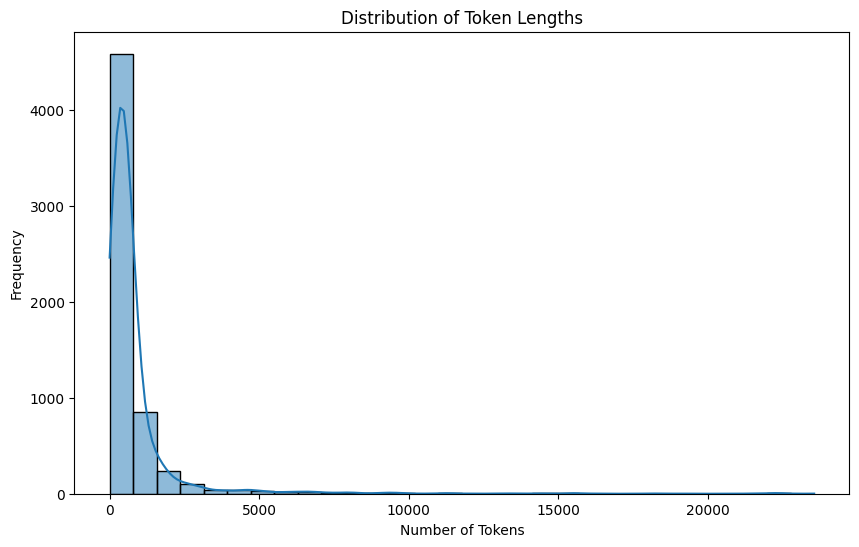

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [ ]:
num_less_than_512 = (token_lengths < 512).sum()
num_less_than_4000 = (token_lengths < 4000).sum()

total_inputs = len(token_lengths)

percentage_less_than_512 = (num_less_than_512 / total_inputs) * 100
percentage_less_than_4000 = (num_less_than_4000 / total_inputs) * 100

print(f"Percentage of inputs with length less than 512 tokens: {percentage_less_than_512:.2f}%")
print(f"Percentage of inputs with length less than 4000 tokens: {percentage_less_than_4000:.2f}%")

Percentage of inputs with length less than 512 tokens: 54.15%
Percentage of inputs with length less than 4000 tokens: 97.24%


As BERT's context window size is $512$, we just keep the samples shorter than 512 tokens.

In [ ]:
df_less_than_512 = gossipcop_df[gossipcop_df.apply(count_tokens, axis=1) < 512]

The result dataset is still balanced.

In [ ]:
label_counts = df_less_than_512['label'].value_counts()

num_real = label_counts.get(0, 0)
num_fake = label_counts.get(1, 0)

print(f"Number of real news articles: {num_real}")
print(f"Number of fake news articles: {num_fake}")

Number of real news articles: 1622
Number of fake news articles: 1620


## Preparing Primary Dataset For Fine-tuning

Firstly, we concatinate columns 'title' and 'content' to a new column named 'text', and remove the old columns.

In [ ]:
df_less_than_512['text'] = df_less_than_512['title'] + '\n' + df_less_than_512['content']

<ipython-input-19-67b74effb8a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_less_than_512['text'] = df_less_than_512['title'] + '\n' + df_less_than_512['content']


In [ ]:
df_less_than_512.drop(['title', 'content'], axis=1, inplace=True)

<ipython-input-20-c90801cc7900>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_less_than_512.drop(['title', 'content'], axis=1, inplace=True)


In [ ]:
df_less_than_512

,id,label,text
1,-4081333587,fake,Zayn Malik shared the gas happy birthday video...
3,-4050914559,fake,"The Weeknd, Selena Gomez Quotes Posted By Holl..."
4,-4024992311,fake,"Tom Holland Not Trying To Date Marisa Tomei, D..."
5,-4005165025,fake,NaN
6,-4038677075,fake,Kris Jenner CAUGHT Getting Flirty With Grimy S...
...,...,...,...
5980,-915430,real,Kourtney Kardashian Freezes Eggs So She Can Ha...
5981,-915516,real,Daily News\nWe use cookies on our website to g...
5984,-915559,real,Prince Harry and Meghan Markle anthrax scare t...
5985,-915478,real,PyeongChang 2018 Winter Olympics\nNew Horizons...


Now we create a Dataset object of this dataframe, and split it to two parts for training and testing.

In [ ]:
from datasets import Dataset
gossipcop_less_than_512_dataset = Dataset.from_pandas(df_less_than_512)

In [ ]:
gossipcop_less_than_512_dataset_train_test = gossipcop_less_than_512_dataset.train_test_split(test_size=0.1)

In [ ]:
gossipcop_less_than_512_dataset_train_test

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'text', '__index_level_0__'],
        num_rows: 2917
    })
    test: Dataset({
        features: ['id', 'label', 'text', '__index_level_0__'],
        num_rows: 325
    })
})

In [ ]:
def remove_none_values(dataset):
    for column in dataset.column_names:
        dataset = dataset.filter(lambda example: example[column] is not None)
    return dataset

gossipcop_less_than_512_dataset_train_test['train'] = remove_none_values(gossipcop_less_than_512_dataset_train_test['train'])
gossipcop_less_than_512_dataset_train_test['test'] = remove_none_values(gossipcop_less_than_512_dataset_train_test['test'])

Filter:   0%|          | 0/2917 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2917 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2917 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2675 [00:00<?, ? examples/s]

Filter:   0%|          | 0/325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/325 [00:00<?, ? examples/s]

Filter:   0%|          | 0/297 [00:00<?, ? examples/s]

## Tokenizing Primary Dataset

Here, we tokenize the 'text' column.

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding, RobertaTokenizer

### BERT tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### RoBERTa tokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Tokenizing

In [ ]:
def tokenize_function(example):
    text = example['text']
    return tokenizer(text, truncation=True, padding='max_length', max_length=512)

In [ ]:
tokenized_dataset = gossipcop_less_than_512_dataset_train_test.map(tokenize_function, batched=True) # Remove original columns to avoid conflicts

Map:   0%|          | 0/2675 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

And, we prepare the column names.

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(['id','text'])
tokenized_dataset = tokenized_dataset.rename_column('label','labels')
tokenized_dataset.with_format('pt')

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2675
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 297
    })
})

'labels' column should be integer.

In [ ]:
label_map = {'fake': 0, 'real': 1}

def map_labels(example):
    example['labels'] = label_map[example['labels']]
    return example


tokenized_dataset['train'] = tokenized_dataset['train'].map(map_labels)
tokenized_dataset['test'] = tokenized_dataset['test'].map(map_labels)

Map:   0%|          | 0/2675 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

## Fine-tuning

### Fine-tuning BERT

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments, DefaultDataCollator

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    data_collator=data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.466213
2,No log,0.454925
3,0.396700,0.479830


TrainOutput(global_step=504, training_loss=0.39488918405203594, metrics={'train_runtime': 802.3814, 'train_samples_per_second': 10.001, 'train_steps_per_second': 0.628, 'total_flos': 2111466219264000.0, 'train_loss': 0.39488918405203594, 'epoch': 3.0})

In [ ]:
model.save_pretrained('drive/MyDrive/LLM/FinalProject/BERT-model')

### Fine-tuning RoBERTa

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments, DefaultDataCollator

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    data_collator=data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.000081
2,No log,0.000046
3,0.009900,0.000039


TrainOutput(global_step=501, training_loss=0.00983346735933638, metrics={'train_runtime': 791.2621, 'train_samples_per_second': 10.119, 'train_steps_per_second': 0.633, 'total_flos': 2106730220267520.0, 'train_loss': 0.00983346735933638, 'epoch': 3.0})

In [ ]:
model.save_pretrained('drive/MyDrive/LLM/FinalProject/RoBERTa-model')

# Evaluation on Primary Dataset (test)

## BERT

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report
import torch
import numpy as np

model_path = 'drive/MyDrive/LLM/FinalProject/BERT-model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [ ]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=512)

tokenized_test = gossipcop_less_than_512_dataset_train_test['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

In [ ]:
tokenized_test = tokenized_test.remove_columns(['id', 'text'])
tokenized_test = tokenized_test.rename_column('label','labels')
tokenized_test.with_format('pt')

Dataset({
    features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 297
})

In [ ]:
label_map = {'fake': 0, 'real': 1}

def map_labels(example):
    example['labels'] = label_map[example['labels']]
    return example


tokenized_test = tokenized_test.map(map_labels)

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

### Base BERT

In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []
label_map = {0: 'fake', 1: 'real'}
with torch.no_grad():
    for i in range(len(tokenized_test)):
        inputs = {k: torch.tensor(tokenized_test[k][i]).unsqueeze(0) for k in ['input_ids', 'attention_mask']}
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
        predictions.append(label_map[pred])
        true_labels.append(tokenized_test['label'][i])

print("Predictions completed.")

Predictions completed.


In [ ]:
target_names = ['fake', 'real']
report = classification_report(true_labels, predictions, target_names=target_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        fake       0.46      1.00      0.63       141
        real       0.00      0.00      0.00       166

    accuracy                           0.46       307
   macro avg       0.23      0.50      0.31       307
weighted avg       0.21      0.46      0.29       307



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine-tuned BERT

In [ ]:
def compute_metrics(predictions, labels):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# test_results = trainer.predict(test_dataset)
test_results = trainer.predict(tokenized_test)

metrics = compute_metrics(test_results.predictions, test_results.label_ids)


Test 1:

In [ ]:
metrics

{'accuracy': 0.7885304659498208,
 'precision': 0.7894736842105263,
 'recall': 0.7720588235294118,
 'f1': 0.7806691449814126}

Test 2:

In [ ]:
metrics

{'accuracy': 0.8080808080808081,
 'precision': 0.7943262411347518,
 'recall': 0.8,
 'f1': 0.797153024911032}

## RoBERTa

### Base RoBERTa

#### Test 1

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import classification_report
import torch
import numpy as np

model_path = 'drive/MyDrive/LLM/FinalProject/RoBERTa-model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [ ]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=512)

tokenized_test = gossipcop_less_than_512_dataset_train_test['test'].map(tokenize_function, batched=True)

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

In [ ]:
model.eval()
predictions = []
true_labels = []
label_map = {0: 'fake', 1: 'real'}
with torch.no_grad():
    for i in range(len(tokenized_test)):
        inputs = {k: torch.tensor(tokenized_test[k][i]).unsqueeze(0) for k in ['input_ids', 'attention_mask']}
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
        predictions.append(label_map[pred])
        true_labels.append(tokenized_test['label'][i])

print("Predictions completed.")

In [ ]:
target_names = ['fake', 'real']
report = classification_report(true_labels, predictions, target_names=target_names)
print("\nClassification Report:")
print(report)

#### Test 2

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Replace the existing compute_metrics function with this one
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

base_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
base_trainer = Trainer(
    model=base_model,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

base_results = base_trainer.evaluate()

# After evaluating the base model, add these print statements
print(f"Base RoBERTa Metrics:")
print(f"Accuracy: {base_results['eval_accuracy']:.4f}")
print(f"Precision: {base_results['eval_precision']:.4f}")
print(f"Recall: {base_results['eval_recall']:.4f}")
print(f"F1-score: {base_results['eval_f1']:.4f}")



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base RoBERTa Metrics:
Accuracy: 0.4875
Precision: 0.4875
Recall: 1.0000
F1-score: 0.6554



Fine-tuned RoBERTa Metrics:


KeyError: 'eval_accuracy'

### Fine-tuned RoBERTa

In [ ]:
def compute_metrics(predictions, labels):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

test_results = trainer.predict(test_dataset)
metrics = compute_metrics(test_results.predictions, test_results.label_ids)


In [ ]:
metrics

{'accuracy': 0.7741935483870968,
 'precision': 0.7354838709677419,
 'recall': 0.8382352941176471,
 'f1': 0.7835051546391751}

In [ ]:
fine_tuned_results

{'eval_loss': 0.47515660524368286,
 'eval_runtime': 8.4821,
 'eval_samples_per_second': 32.893,
 'eval_steps_per_second': 2.122,
 'epoch': 3.0}

# Evaluation on Secondary Dataset

## BERT

### Tokenizing Dataset

In [ ]:
# normal_df = pd.read_csv('drive/MyDrive/LLM/FinalProject/gossipcop_complete_cleaned_less512.csv')
normal_df = df_less_than_512.copy()
paraphrased_df = pd.read_csv('drive/MyDrive/LLM/FinalProject/gossipcop_paraphrased (2).csv')

In [ ]:
import pandas as pd
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Function to count tokens in a given text
def count_tokens(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

In [ ]:
paraphrased_df['token_count'] = paraphrased_df['paraphrased'].apply(count_tokens)

filtered_paraphrased_df = paraphrased_df[paraphrased_df['token_count'] < 512]
filtered_paraphrased_df = filtered_paraphrased_df[filtered_paraphrased_df['paraphrased'] != '0']

# Number of rows that meet the condition
num_rows = len(filtered_paraphrased_df)

# Select the same number of rows from df2 where the labels are 'real'
filtered_normal_df = normal_df[normal_df['label'] == 'real'].head(num_rows)

Token indices sequence length is longer than the specified maximum sequence length for this model (713 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from datasets import Dataset
# Create a new dataframe with 'text' and 'label' columns
paraphrased_data = filtered_paraphrased_df[['paraphrased', 'label']].rename(columns={'paraphrased': 'text', 'label': 'labels'})
normal_data = filtered_normal_df[['content', 'label']].rename(columns={'content': 'text', 'label': 'labels'})

# Merge the dataframes by stacking them vertically
merged_df = pd.concat([paraphrased_data, normal_data], ignore_index=True)

# Create a dataset from the merged DataFrame
dataset = Dataset.from_pandas(merged_df)



In [ ]:
def remove_none_values(dataset):
    # Check each column for None values
    for column in dataset.column_names:
        dataset = dataset.filter(lambda example: example[column] is not None)
    return dataset

dataset = remove_none_values(dataset)

Filter:   0%|          | 0/976 [00:00<?, ? examples/s]

Filter:   0%|          | 0/960 [00:00<?, ? examples/s]

In [ ]:
# Tokenize the text column
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

In [ ]:
label_map = {'fake': 0, 'real': 1}

def map_labels(example):
    example['labels'] = label_map[example['labels']]
    return example

tokenized_dataset = tokenized_dataset.map(map_labels)


Map:   0%|          | 0/960 [00:00<?, ? examples/s]

### Base BERT

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score
import numpy as np

# Replace the existing compute_metrics function with this one
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

base_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
base_trainer = Trainer(
    model=base_model,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics,
)

base_results = base_trainer.evaluate()

# After evaluating the base model, add these print statements
print(f"Base RoBERTa Metrics:")
print(f"Accuracy: {base_results['eval_accuracy']:.4f}")
print(f"Precision: {base_results['eval_precision']:.4f}")
print(f"Recall: {base_results['eval_recall']:.4f}")
print(f"F1-score: {base_results['eval_f1']:.4f}")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base RoBERTa Metrics:
Accuracy: 0.3792
Precision: 0.4182
Recall: 0.6716
F1-score: 0.5154


### Fine-tuned BERT

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score
import numpy as np

# Replace the existing compute_metrics function with this one
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

finetuned_model = BertForSequenceClassification.from_pretrained('drive/MyDrive/LLM/FinalProject/BERT-model', num_labels=2)
finetuned_trainer = Trainer(
    model=finetuned_model,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics,
)

finetuned_results = finetuned_trainer.evaluate()

# After evaluating the base model, add these print statements
print(f"Base RoBERTa Metrics:")
print(f"Accuracy: {finetuned_results['eval_accuracy']:.4f}")
print(f"Precision: {finetuned_results['eval_precision']:.4f}")
print(f"Recall: {finetuned_results['eval_recall']:.4f}")
print(f"F1-score: {finetuned_results['eval_f1']:.4f}")



Base RoBERTa Metrics:
Accuracy: 0.7542
Precision: 0.6909
Recall: 0.9047
F1-score: 0.7835


## RoBERTa

### Tokenizing Dataset

In [ ]:
normal_df = pd.read_csv('gossipcop_complete_cleaned_less512.csv')
paraphrased_df = pd.read_csv('gossipcop_paraphrased (2).csv')

In [ ]:
import pandas as pd
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def count_tokens(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

In [ ]:
paraphrased_df['token_count'] = paraphrased_df['paraphrased'].apply(count_tokens)

filtered_paraphrased_df = paraphrased_df[paraphrased_df['token_count'] < 512]
filtered_paraphrased_df = filtered_paraphrased_df[filtered_paraphrased_df['paraphrased'] != '0']


num_rows = len(filtered_paraphrased_df)

filtered_normal_df = normal_df[normal_df['label'] == 'real'].head(num_rows)

Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from datasets import Dataset
paraphrased_data = filtered_paraphrased_df[['paraphrased', 'label']].rename(columns={'paraphrased': 'text', 'label': 'labels'})
normal_data = filtered_normal_df[['content', 'label']].rename(columns={'content': 'text', 'label': 'labels'})

merged_df = pd.concat([paraphrased_data, normal_data], ignore_index=True)

dataset = Dataset.from_pandas(merged_df)



In [ ]:
def remove_none_values(dataset):
    for column in dataset.column_names:
        dataset = dataset.filter(lambda example: example[column] is not None)
    return dataset

dataset = remove_none_values(dataset)

Filter:   0%|          | 0/964 [00:00<?, ? examples/s]

Filter:   0%|          | 0/948 [00:00<?, ? examples/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/948 [00:00<?, ? examples/s]

In [ ]:
label_map = {'fake': 0, 'real': 1}

def map_labels(example):
    example['labels'] = label_map[example['labels']]
    return example

tokenized_dataset = tokenized_dataset.map(map_labels)


Map:   0%|          | 0/948 [00:00<?, ? examples/s]

In [ ]:
fine_tuned_results

{'eval_loss': 0.47515660524368286,
 'eval_runtime': 8.4821,
 'eval_samples_per_second': 32.893,
 'eval_steps_per_second': 2.122,
 'epoch': 3.0}

### Base RoBERTa

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

base_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
base_trainer = Trainer(
    model=base_model,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics,
)

base_results = base_trainer.evaluate()

print(f"Base RoBERTa Metrics:")
print(f"Accuracy: {base_results['eval_accuracy']:.4f}")
print(f"Precision: {base_results['eval_precision']:.4f}")
print(f"Recall: {base_results['eval_recall']:.4f}")
print(f"F1-score: {base_results['eval_f1']:.4f}")



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base RoBERTa Metrics:
Accuracy: 0.4599
Precision: 0.4688
Recall: 0.7425
F1-score: 0.5748


### Fine-tuned RoBERTa

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

finetuned_model = RobertaForSequenceClassification.from_pretrained('drive/MyDrive/LLM/FinalProject/roberta_finetuned', num_labels=2)
finetuned_trainer = Trainer(
    model=finetuned_model,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics,
)

finetuned_results = finetuned_trainer.evaluate()

print(f"Base RoBERTa Metrics:")
print(f"Accuracy: {finetuned_results['eval_accuracy']:.4f}")
print(f"Precision: {finetuned_results['eval_precision']:.4f}")
print(f"Recall: {finetuned_results['eval_recall']:.4f}")
print(f"F1-score: {finetuned_results['eval_f1']:.4f}")



Base RoBERTa Metrics:
Accuracy: 0.6930
Precision: 0.6308
Recall: 0.9056
F1-score: 0.7436


#Fine-tuning RoBERTa on Secondary Dataset

## Fine-tuning

In [ ]:
df = pd.read_csv("gossipcop_paraphrased_final.csv")

In [ ]:
df['text1'] = df['title'] + '\n' + df['content']
df['text2'] = df['title'] + '\n' + df['paraphrased']
df.drop(['title', 'content', 'id', 'Unnamed: 0', 'paraphrased'], axis=1, inplace=True)
df_new = df.copy()
df_new['text1'] = df_new['text1'] + ' ' + df_new['text2']
result = pd.concat([df[['label', 'text1']], df_new[['label', 'text1']]])
df = result.reset_index(drop=True)
df['text1'] = df['text1'].astype(str)
df['label'] = df['label'].map({'fake': 0, 'real': 1}).astype(int)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text1'], padding='max_length', truncation=True, max_length=512)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print("\nTrain dataset info:")
print(train_dataset)
print("\nTest dataset info:")
print(test_dataset)

train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text1'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['text1'])

train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

print("\nTrain dataset after processing:")
print(train_dataset)
print("\nTest dataset after processing:")
print(test_dataset)


Train dataset info:
Dataset({
    features: ['label', 'text1', '__index_level_0__'],
    num_rows: 1440
})

Test dataset info:
Dataset({
    features: ['label', 'text1', '__index_level_0__'],
    num_rows: 160
})


Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]


Train dataset after processing:
Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1440
})

Test dataset after processing:
Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 160
})


In [ ]:
model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/roberta_finetuned', num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.155749
2,No log,0.119099
3,No log,0.158367


TrainOutput(global_step=270, training_loss=0.11777420750370732, metrics={'train_runtime': 414.3566, 'train_samples_per_second': 10.426, 'train_steps_per_second': 0.652, 'total_flos': 1136639759155200.0, 'train_loss': 0.11777420750370732, 'epoch': 3.0})

In [ ]:
model.save_pretrained('/content/drive/My Drive/roberta2_finetuned')

## Evaluation on Secondary Dataset

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(predictions, labels):
    preds = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

test_results = trainer.predict(test_dataset)
metrics = compute_metrics(test_results.predictions, test_results.label_ids)
print(f"\nFine-tuned RoBERTa Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1-score: {metrics['f1']:.4f}")


Fine-tuned RoBERTa Metrics:
Accuracy: 0.9625
Precision: 0.9762
Recall: 0.9535
F1-score: 0.9647
